In [1]:
from IPython.display import clear_output

In [2]:
from google.colab import drive

drive.mount('/content/drive/')

clear_output()

In [3]:
import os
import re

import random

from operator import itemgetter, attrgetter
from itertools import islice
from collections import defaultdict

import numpy as np
import pandas as pd

from tqdm import tqdm

In [4]:
if not os.path.isdir('idao_dataset'):
    !pip install wldhx.yadisk-direct -qqq
    !curl -L $(yadisk-direct https://yadi.sk/d/UJ8DEma9LHRMsg) -o track_1.tar
    !tar xvf track_1.tar
    !rm track_1.tar

    !wget "https://s273vla.storage.yandex.net/rdisk/5128bdafdd45c83c78baf54110dfcaeb94bc5a5965f3b95ee74fb3add1249e63/606476ac/bgrUSZap4U7F2FfQ-AWWcVCFnOObN1NGdFdocrjauwwvrixOJyYxAoSxQKitKzeuFt9xHujJSr2uP71e7TVa8Q==?uid=0&filename=track_1_private_test_final_27_03.zip&disposition=attachment&hash=OGTrMEeD15wCqdRSSwqp1R7gwsF1YKDyVMBb9IvYl2THpFxspvPSVhI6UMio3CQsq/J6bpmRyOJonT3VoXnDag%3D%3D%3A/track_1_private_test_final_27_03.zip&limit=0&content_type=application%2Fzip&owner_uid=44214498&fsize=2712019001&hid=3fb11601607208c5cf34a9916e16636d&media_type=compressed&tknv=v2&rtoken=FqG5isfuH4Mj&force_default=no&ycrid=na-752c92c10c06f1b8bb6c257a22476815-downloader12h&ts=5bed4f3ca0300&s=f992783ca00a20bc8e13573bfdaaf1d3bb20bb7c32818360d01fc9e3aad446c5&pb=U2FsdGVkX1_WKjvc-NSztBfdJgaYjvIxPFc5cG_hyWttwgTQYnpNQfXhQkke0CcMk7qSEiuNbial3OCBpLkP2ISxB-r5LlL5xWQSCIW4Gxs" -O track_1_private_new.zip
    !unzip track_1_private_new.zip
    !rm -r __MACOSX
    !mv private_test idao_dataset/private_test_new
    !rm track_1_private_new.zip

clear_output()

In [5]:
DATA_DIR = "./idao_dataset/"
WORK_DIR = "/content/drive/My Drive/idao-2021"

In [6]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [7]:
import cv2

import albumentations as A

from skimage.measure import regionprops, label as regionlabel

from torch.utils.data.dataset import IterableDataset, Dataset

from PIL import Image
from multiprocessing import Pool, cpu_count

from pathlib import Path

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold


NUM_THREADS = cpu_count()

MAPPING_CLASS_INV = ['He_NR', 'ER']
MAPPING_CLASS = {v: k for k, v in enumerate(MAPPING_CLASS_INV)}

MAPPING_VALUE_INV = [1, 3, 6, 10, 20, 30]
MAPPING_VALUE = {v: k for k, v in enumerate(MAPPING_VALUE_INV)}
MAPPING_VALUE_INV = np.asarray(MAPPING_VALUE_INV)

IMG_SIZE_ORIGIN = 576
IMG_SIZE_ORIGIN_DIV_2 = IMG_SIZE_ORIGIN // 2

IMG_SIZE_SELECT = 120
IMG_SIZE_SELECT_DIV_2 = IMG_SIZE_SELECT // 2

kernel_5 = np.ones((5, 5), np.uint8)


def create_mask(img, thrsh=100, border=10):
    # mask = cv2.medianBlur(img, 3)
    mask = (img > thrsh).astype(np.uint8)

    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel_5)
    mask = cv2.dilate(mask, kernel_5, iterations=1)
    
    mask[:border, :] = mask[-border:, :] = 0
    mask[:, :border] = mask[:, -border:] = 0
    
    return mask


def fix_bbox(img_shape, bbox):
    y_min, x_min, y_max, x_max = bbox

    h_box, w_box = y_max - y_min, x_max - x_min
    h_max, w_max = img_shape

    assert h_box <= h_max and w_box <= w_max

    if y_min < 0:
        y_min, y_max = 0, h_box
    elif y_max > h_max:
        y_min, y_max = h_max - h_box, h_max

    if x_min < 0:
        x_min, x_max = 0, w_box
    elif x_max > w_max:
        x_min, x_max = w_max - w_box, w_max

    return y_min, x_min, y_max, x_max


def find_object_bbox(img, area_thrsh=150):
    img_mask = create_mask(img)
    img_mask = regionlabel(img_mask)
    
    props = regionprops(img_mask)
    props = max(props, key=attrgetter('area'), default=None)

    if props is not None:
        centroid_y, centroid_x = map(int, props.centroid)
    else:
        centroid_y, centroid_x = IMG_SIZE_ORIGIN_DIV_2, IMG_SIZE_ORIGIN_DIV_2

    y_min, x_min, y_max, x_max = (
        centroid_y - IMG_SIZE_SELECT_DIV_2,
        centroid_x - IMG_SIZE_SELECT_DIV_2,
        centroid_y + IMG_SIZE_SELECT_DIV_2,
        centroid_x + IMG_SIZE_SELECT_DIV_2,
    )

    bbox = x_min, y_min, x_max, y_max
    bbox = fix_bbox(img.shape, bbox)
    return bbox


def process_image(img_path):
    img_name = os.path.basename(img_path)
    img_name_re = re.search('__CYGNO_\d+_\d+_(\w*)_(\d+)_keV', img_name)
    if img_name_re:
        img_class = MAPPING_CLASS[img_name_re.group(1)]
        img_value = MAPPING_VALUE[int(img_name_re.group(2))]
    else:
        img_class, img_value = None, None

    img = np.asarray(Image.open(img_path))
    x_min, y_min, x_max, y_max = find_object_bbox(img)
    img = img[y_min:y_max, x_min:x_max]
    img = cv2.medianBlur(img, ksize=3)

    return img, img_class, img_value, img_name


class IDAODataset(Dataset):
    def __init__(self, images, labels, values, filenames, batch_size=128,
                 transform=None, apply_transform_optional=True, random_state=None):
        super(IDAODataset, self).__init__()

        self.images = images
        self.labels = labels
        self.values = values

        self.filenames = filenames
        
        self.random_state = np.random.RandomState(random_state)
        self.indices = np.arange(len(self.images))
        self.batch_size = batch_size

        self.transform = transform
        self.transform_fn = self.create_transform_fn(transform, apply_transform_optional)

    def create_transform_fn(self, transform, apply_transform_optional):
        if transform is None:
            return None

        transform = [tr for tr, is_required in transform
                     if is_required or apply_transform_optional]
        
        if not transform:
            return None

        return A.Compose(transform)

    def __getitem__(self, idx):
        if idx < 0:
            idx = len(self) + idx

        if not (0 <= idx < len(self)):
            raise IndexError(idx)

        offset_beg, offset_end = idx * self.batch_size, (idx + 1) * self.batch_size
        item_slice = self.indices[offset_beg:offset_end]

        images = self.images[item_slice]

        if self.transform_fn is not None:
            images = [self.transform_fn(image=image)["image"] for image in images]

        images = np.asarray(images)
        images = torch.tensor(images, dtype=torch.float, device=device).unsqueeze(1)

        if self.labels is not None and self.values is not None:
            labels = torch.tensor(self.labels[item_slice], dtype=torch.float, device=device).unsqueeze(-1)
            values = torch.tensor(self.values[item_slice], dtype=torch.long, device=device)
        else:
            labels, values = None, None

        return (images, labels, values)

    def __len__(self):
        return int(np.ceil(self.indices.shape[0] / self.batch_size))

    def shuffle(self):
        self.random_state.shuffle(self.indices)

    def set_random_state(self, random_state=None):
        self.random_state = np.random.RandomState(random_state)

    @classmethod
    def from_path(cls, path, batch_size=128, transform=None, apply_transform_optional=True,
                  has_target=True, random_state=None):
        with Pool(processes=NUM_THREADS) as pool:
            images_paths = Path(path).rglob('*.png')
            images_paths = sorted(map(str, images_paths))
            images = pool.imap(process_image, tqdm(images_paths, position=0), chunksize=10)
            images = list(images)

        return cls(
            images=np.asarray([img for img, _, _, _ in images]),
            labels=np.asarray([cls for _, cls, _, _ in images]) if has_target else None,
            values=np.asarray([val for _, _, val, _ in images]) if has_target else None,
            filenames=np.asarray([name for _, _, _, name in images]),
            batch_size=batch_size,
            transform=transform,
            apply_transform_optional=apply_transform_optional,
            random_state=random_state,
        )

    def _train_test_split(self, indices_train, indices_test):
        cls = type(self)
        
        dataset_train = cls(
            images=self.images,
            labels=self.labels,
            values=self.values,
            filenames=self.filenames,
            transform=self.transform,
            apply_transform_optional=True,
            batch_size=self.batch_size,
        )

        dataset_test = cls(
            images=self.images,
            labels=self.labels,
            values=self.values,
            filenames=self.filenames,
            transform=self.transform,
            apply_transform_optional=False,
            batch_size=self.batch_size,
        )

        # ad hoc for no copy in fancy indexing
        dataset_train.indices = self.indices[indices_train]
        dataset_test.indices  = self.indices[indices_test]

        return dataset_train, dataset_test

    def split(self, test_size=0.3, random_state=None):
        indices_train, indices_test = train_test_split(
            self.indices, test_size=test_size, random_state=random_state)
        return self._train_test_split(indices_train, indices_test)

    def cv_split(self, n_splits=5, shuffle=True, stratified=True, random_state=None):
        if stratified:
            strata_labels = self.labels[self.indices]
            strata_values = self.values[self.indices]
            strata = (strata_labels.max() + 1) * strata_values + strata_labels

            print(repr(np.bincount(strata).reshape(-1, 2)))

            kf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
            splits = kf.split(self.indices, strata)
        else:
            kf = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
            splits = kf.split(self.indices)

        for indices_train, indices_test in splits:
            yield self._train_test_split(indices_train, indices_test)

In [8]:
# sorted by file construction

examples_extra = pd.read_csv(os.path.join(WORK_DIR, 'examples_extra.csv'), index_col=['id'])
examples_extra.index = examples_extra.index + '.png'
examples_extra.head()

,cluster,label,value
id,,,
0002894871bb30af2670648c58b2506e9801a321.png,6,1,20
000a95ca23df016a149ff9af94b6e9d8633d6691.png,10,0,30
000c45d729066044e3dd3f885fddf013b845b6d7.png,6,1,20
0011f80e44faa713714ead6aeab3b2f9db54aebd.png,8,0,10
0019c489db95ca9ee6e558274700ef3d76d37532.png,10,0,30


In [9]:
examples_extra_values = examples_extra['value'].to_dict()
examples_extra_labels = examples_extra['label'].to_dict()

In [10]:
%%time

random.seed(68)

try:
    dataset = IDAODataset(
        images=dataset.images,
        labels=dataset.labels,
        values=dataset.values,
        filenames=dataset.filenames,
        transform=dataset.transform,
        apply_transform_optional=True,
        batch_size=dataset.batch_size,
    )
except NameError as e:
    print(e)

    dataset = IDAODataset.from_path(
        path='idao_dataset/train/',
        transform=[
            (A.Flip(p=0.25), False),
            (A.RandomRotate90(p=0.25), False),
        ],
        apply_transform_optional=True,
        has_target=True,
    )

    dataset_test_old = IDAODataset.from_path(
        path='idao_dataset/private_test/',
        transform=dataset.transform,
        apply_transform_optional=True,
        has_target=False,
    )

    dataset_test_new = IDAODataset.from_path(
        path='idao_dataset/private_test_new/',
        transform=dataset.transform,
        apply_transform_optional=True,
        has_target=False,
    )

    dataset_test = IDAODataset(
        images=np.vstack([dataset_test_old.images, dataset_test_new.images]),
        labels=None,
        values=None,
        filenames=np.hstack([dataset_test_old.filenames, dataset_test_new.filenames]),
        transform=dataset.transform,
        apply_transform_optional=True,
    )

    del dataset_test_old, dataset_test_new

    mask = np.isin(dataset_test.filenames, examples_extra.index.values, assume_unique=True)
    filenames = dataset_test.filenames[mask]

    dataset_test = IDAODataset(
        images=dataset_test.images[mask],
        labels=np.asarray([examples_extra_labels[f] for f in filenames]),
        values=np.asarray([MAPPING_VALUE[examples_extra_values[f]] for f in filenames]),
        filenames=filenames,
        transform=dataset.transform,
        apply_transform_optional=True,
        batch_size=dataset.batch_size,
    )

    dataset = IDAODataset(
        images=np.vstack([dataset.images, dataset_test.images]),
        labels=np.hstack([dataset.labels, dataset_test.labels]),
        values=np.hstack([dataset.values, dataset_test.values]),
        filenames=np.hstack([dataset.filenames, dataset_test.filenames]),
        transform=dataset.transform,
        apply_transform_optional=True,
        batch_size=dataset.batch_size,
    )

    del dataset_test

dataset_folds = list(dataset.cv_split(random_state=42))

for train, valid in dataset_folds:
    train.set_random_state(9872)
    valid.set_random_state(9872)

len(dataset_folds)

name 'dataset' is not defined


100%|██████████| 15058/15058 [01:21<00:00, 185.50it/s]


array([[2177,  803],
       [ 802, 2243],
       [2255, 4001],
       [4002, 2272],
       [2208, 4002],
       [4002, 2237]])
CPU times: user 11.6 s, sys: 3.02 s, total: 14.7 s
Wall time: 4min 3s


In [11]:
dataset.images.shape

(31004, 120, 120)

In [12]:
import torch.nn as nn
import torch.nn.functional as F


class IDAONet(nn.Module):
    def __init__(self):
        super(IDAONet, self).__init__()

        self._conv = nn.Sequential(
            nn.BatchNorm2d(1),

            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=3),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=3),

            nn.Flatten(),
            nn.ReLU(),
        )

        self._cls_labels = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(6272, 500),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(500, 1),
        )

        self._cls_values = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(6272, 500),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(500, len(MAPPING_VALUE_INV)),
        )

    def forward(self, images):
        images = self._conv(images)
        labels = self._cls_labels(images)
        values = self._cls_values(images)
        return labels, values

In [13]:
net = IDAONet().to(device)
net

IDAONet(
  (_conv): Sequential(
    (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): ReLU()
  )
  (_cls_labels): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=6272, out_features=500, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=500, out_features=1, bias=True)
  )
  (_cls_values): Sequential(
    (0): Dr

In [14]:
def train_func(model: nn.Module, iterator, criteria, optimizer, verbose=True):
    epoch_loss = 0
    num_samples = 0
    
    criterion_labels, criterion_values = criteria

    iterator.shuffle()
    model.train()
    
    if verbose:
        iterator = tqdm(iterator, position=0, desc='batches')

    for images, labels_true, values_true in iterator:
        optimizer.zero_grad()

        labels_pred, values_pred = model(images)

        loss = criterion_labels(labels_pred, labels_true) + \
               criterion_values(values_pred, values_true)
        loss.backward()

        epoch_loss += loss.item()
        num_samples += images.shape[0]

        optimizer.step()

    return epoch_loss / num_samples, np.nan

In [15]:
from sklearn.metrics import roc_auc_score, mean_absolute_error
from sklearn.metrics import roc_curve


def evaluate_func(model: nn.Module, iterator, verbose=True, return_misclassified=False):
    epoch_loss = 0
    num_samples = 0

    model.eval()

    if verbose:
        iterator_ = tqdm(iterator, position=0, desc='batches')
    else:
        iterator_ = iterator
    
    labels_pred_all, values_pred_all = [], []

    with torch.no_grad():
        for images, labels_true, values_true in iterator_:
            labels_pred, values_pred = model(images)
            labels_pred = torch.sigmoid(labels_pred)

            labels_pred = labels_pred.cpu().detach().numpy().ravel()
            values_pred = values_pred.cpu().detach().numpy().argmax(axis=1).ravel()

            labels_pred_all.append(labels_pred)
            values_pred_all.append(values_pred)

    labels_pred = np.concatenate(labels_pred_all)
    values_pred = np.concatenate(values_pred_all)

    labels_true = iterator.labels[iterator.indices]
    values_true = iterator.values[iterator.indices]

    values_pred = MAPPING_VALUE_INV[values_pred]
    values_true = MAPPING_VALUE_INV[values_true]

    score_auc = roc_auc_score(labels_true, labels_pred)
    score_mae = mean_absolute_error(values_true, values_pred)

    metrics = {'auc': score_auc, 'mae': score_mae}
    score = score_auc - score_mae

    if return_misclassified:
        fpr, tpr, thresholds = roc_curve(labels_true, labels_pred)
        threshold_best = thresholds[np.argmax(tpr - fpr)]

        errors = ((labels_true - (labels_pred > threshold_best)) != 0).astype(int) * 1 + \
                 ((values_true - values_pred) != 0).astype(int) * 2
        mask = errors > 0
        return iterator.filenames[iterator.indices[mask]], errors[mask]

    return np.nan, score, metrics

In [16]:
import torch.optim as optim

criteria = [
    torch.nn.BCEWithLogitsLoss(reduction='sum'),
    torch.nn.CrossEntropyLoss(reduction='sum'),
]

optimizer = optim.Adam(lr=0.001, params=net.parameters())
_ = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.75)

In [17]:
def update_lr(optimizer, gamma):
    for params in optimizer.param_groups:
        params['lr'] *= gamma

In [18]:
CHECKPOINTS = os.path.join(WORK_DIR, "checkpoints_2.track1")

!rm -r "{CHECKPOINTS}" || true
!mkdir -p "{CHECKPOINTS}"
!ls -l "{CHECKPOINTS}"

total 0


In [19]:
class EarlyStopping:
    def __init__(self, max_attempt=5):
        self.attempt = -1
        self.max_attempt = max_attempt
        
        self.best_score = -1
        self.best_attempt = -1

    def add_score(self, score):
        self.attempt += 1

        if self.best_score < score:
            self.best_score = score
            self.best_attempt = self.attempt

    def is_valid(self):
        return (self.attempt - self.best_attempt) <= self.max_attempt

In [20]:
NUM_EPOCHS = 70
NUM_ATTEMPTS = 10


es = EarlyStopping(max_attempt=NUM_ATTEMPTS)


def weight_reset(m):
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()


params = {
    'criteria': criteria,
    'optimizer': optimizer,
    'verbose': False,
}


STR_OFFSET = ' ' * 11


for epoch in range(NUM_EPOCHS):
    scores = defaultdict(list)

    model_path = os.path.join(CHECKPOINTS, f'epoch_{epoch+1}')
    !mkdir -p "{model_path}"

    for fold, (train, valid) in enumerate(tqdm(dataset_folds), 1):
        model_prev = os.path.join(CHECKPOINTS, f'epoch_{epoch}', f'model_fold_{fold}.model')
        model_next = os.path.join(CHECKPOINTS, f'epoch_{epoch+1}', f'model_fold_{fold}.model')

        is_trained = os.path.isfile(model_next)

        if not is_trained:
            if epoch > 0:
                net.load_state_dict(torch.load(model_prev))
            else:
                net.apply(weight_reset)

            train_loss, train_score = train_func(net, train, **params)
            torch.save(net.state_dict(), model_next)
        else:
            net.load_state_dict(torch.load(model_next))
            train_loss, train_score = np.nan, np.nan

        valid_loss, valid_score, valid_metrics = evaluate_func(net, valid, verbose=False)
        
        scores['train_loss'].append(train_loss)
        scores['valid_loss'].append(valid_loss)

        scores['train_score'].append(train_score)
        scores['valid_score'].append(valid_score)

        for k, v in valid_metrics.items():
            scores['valid_' + k].append(v)

    train_loss, train_score = np.mean(scores['train_loss']), np.mean(scores['train_score'])
    valid_loss, valid_score = np.mean(scores['valid_loss']), np.mean(scores['valid_score'])
    
    valid_auc, valid_mae = np.mean(scores['valid_auc']), np.mean(scores['valid_mae'])

    print()
    print(f"Epoch = {epoch+1:02d}; "
          f"Train Loss: {train_loss:.6f}; Train Score: {train_score:.6f}; "
          f"Val. Loss: {valid_loss:.6f}; Val. Score: {valid_score:.6f}")
    print(STR_OFFSET, f"Val. AUC: {valid_auc:.6f}; Val. MAE: {valid_mae:.6f}")

    if (epoch + 1) % 5 == 0:
        update_lr(optimizer, 0.75)

    es.add_score(valid_score)
    if not es.is_valid():
        break

    epoch_remove = epoch - (NUM_ATTEMPTS + 1)
    if epoch_remove >= 0:
        model_path = os.path.join(CHECKPOINTS, f'epoch_{epoch_remove+1}')
        !rm -r "{model_path}"

100%|██████████| 5/5 [00:36<00:00,  7.29s/it]


Epoch = 01; Train Loss: 1.125851; Train Score: nan; Val. Loss: nan; Val. Score: 0.669519
            Val. AUC: 0.992416; Val. MAE: 0.322897



100%|██████████| 5/5 [00:37<00:00,  7.41s/it]


Epoch = 02; Train Loss: 0.378249; Train Score: nan; Val. Loss: nan; Val. Score: 0.730233
            Val. AUC: 0.999072; Val. MAE: 0.268839



100%|██████████| 5/5 [00:38<00:00,  7.62s/it]


Epoch = 03; Train Loss: 0.276989; Train Score: nan; Val. Loss: nan; Val. Score: 0.755611
            Val. AUC: 0.998642; Val. MAE: 0.243030



100%|██████████| 5/5 [00:38<00:00,  7.69s/it]


Epoch = 04; Train Loss: 0.241078; Train Score: nan; Val. Loss: nan; Val. Score: 0.798692
            Val. AUC: 0.999634; Val. MAE: 0.200942



100%|██████████| 5/5 [00:38<00:00,  7.66s/it]


Epoch = 05; Train Loss: 0.219081; Train Score: nan; Val. Loss: nan; Val. Score: 0.768769
            Val. AUC: 0.999672; Val. MAE: 0.230903



100%|██████████| 5/5 [00:38<00:00,  7.71s/it]


Epoch = 06; Train Loss: 0.179268; Train Score: nan; Val. Loss: nan; Val. Score: 0.859371
            Val. AUC: 0.999836; Val. MAE: 0.140466



100%|██████████| 5/5 [00:38<00:00,  7.67s/it]


Epoch = 07; Train Loss: 0.175092; Train Score: nan; Val. Loss: nan; Val. Score: 0.887168
            Val. AUC: 0.999862; Val. MAE: 0.112695



100%|██████████| 5/5 [00:38<00:00,  7.70s/it]


Epoch = 08; Train Loss: 0.170008; Train Score: nan; Val. Loss: nan; Val. Score: 0.911015
            Val. AUC: 0.999777; Val. MAE: 0.088763



100%|██████████| 5/5 [00:38<00:00,  7.68s/it]


Epoch = 09; Train Loss: 0.158591; Train Score: nan; Val. Loss: nan; Val. Score: 0.900653
            Val. AUC: 0.999834; Val. MAE: 0.099181



100%|██████████| 5/5 [00:38<00:00,  7.67s/it]


Epoch = 10; Train Loss: 0.150440; Train Score: nan; Val. Loss: nan; Val. Score: 0.907986
            Val. AUC: 0.999876; Val. MAE: 0.091891



100%|██████████| 5/5 [00:38<00:00,  7.72s/it]


Epoch = 11; Train Loss: 0.130648; Train Score: nan; Val. Loss: nan; Val. Score: 0.917354
            Val. AUC: 0.999924; Val. MAE: 0.082570



100%|██████████| 5/5 [00:38<00:00,  7.69s/it]


Epoch = 12; Train Loss: 0.124227; Train Score: nan; Val. Loss: nan; Val. Score: 0.918190
            Val. AUC: 0.999890; Val. MAE: 0.081700



100%|██████████| 5/5 [00:38<00:00,  7.67s/it]


Epoch = 13; Train Loss: 0.118836; Train Score: nan; Val. Loss: nan; Val. Score: 0.923076
            Val. AUC: 0.999936; Val. MAE: 0.076861



100%|██████████| 5/5 [00:38<00:00,  7.71s/it]


Epoch = 14; Train Loss: 0.119367; Train Score: nan; Val. Loss: nan; Val. Score: 0.940648
            Val. AUC: 0.999834; Val. MAE: 0.059186



100%|██████████| 5/5 [00:38<00:00,  7.66s/it]


Epoch = 15; Train Loss: 0.117902; Train Score: nan; Val. Loss: nan; Val. Score: 0.902334
            Val. AUC: 0.999547; Val. MAE: 0.097213



100%|██████████| 5/5 [00:38<00:00,  7.67s/it]


Epoch = 16; Train Loss: 0.101217; Train Score: nan; Val. Loss: nan; Val. Score: 0.940204
            Val. AUC: 0.999939; Val. MAE: 0.059734



100%|██████████| 5/5 [00:38<00:00,  7.71s/it]


Epoch = 17; Train Loss: 0.097770; Train Score: nan; Val. Loss: nan; Val. Score: 0.947107
            Val. AUC: 0.999875; Val. MAE: 0.052767



100%|██████████| 5/5 [00:38<00:00,  7.68s/it]


Epoch = 18; Train Loss: 0.098796; Train Score: nan; Val. Loss: nan; Val. Score: 0.916509
            Val. AUC: 0.999787; Val. MAE: 0.083278



100%|██████████| 5/5 [00:38<00:00,  7.70s/it]


Epoch = 19; Train Loss: 0.096705; Train Score: nan; Val. Loss: nan; Val. Score: 0.946982
            Val. AUC: 0.999911; Val. MAE: 0.052929



100%|██████████| 5/5 [00:38<00:00,  7.67s/it]


Epoch = 20; Train Loss: 0.094484; Train Score: nan; Val. Loss: nan; Val. Score: 0.942314
            Val. AUC: 0.999952; Val. MAE: 0.057638



100%|██████████| 5/5 [00:38<00:00,  7.66s/it]


Epoch = 21; Train Loss: 0.083864; Train Score: nan; Val. Loss: nan; Val. Score: 0.950564
            Val. AUC: 0.999978; Val. MAE: 0.049413



100%|██████████| 5/5 [00:38<00:00,  7.71s/it]


Epoch = 22; Train Loss: 0.083917; Train Score: nan; Val. Loss: nan; Val. Score: 0.941599
            Val. AUC: 0.999947; Val. MAE: 0.058347



100%|██████████| 5/5 [00:38<00:00,  7.67s/it]


Epoch = 23; Train Loss: 0.083581; Train Score: nan; Val. Loss: nan; Val. Score: 0.948968
            Val. AUC: 0.999961; Val. MAE: 0.050993



100%|██████████| 5/5 [00:38<00:00,  7.66s/it]


Epoch = 24; Train Loss: 0.080962; Train Score: nan; Val. Loss: nan; Val. Score: 0.950247
            Val. AUC: 0.999951; Val. MAE: 0.049703



100%|██████████| 5/5 [00:38<00:00,  7.71s/it]


Epoch = 25; Train Loss: 0.081875; Train Score: nan; Val. Loss: nan; Val. Score: 0.947975
            Val. AUC: 0.999871; Val. MAE: 0.051896



100%|██████████| 5/5 [00:38<00:00,  7.66s/it]



Epoch = 26; Train Loss: 0.074051; Train Score: nan; Val. Loss: nan; Val. Score: 0.957749
            Val. AUC: 0.999969; Val. MAE: 0.042220


100%|██████████| 5/5 [00:38<00:00,  7.66s/it]


Epoch = 27; Train Loss: 0.071779; Train Score: nan; Val. Loss: nan; Val. Score: 0.953658
            Val. AUC: 0.999974; Val. MAE: 0.046317



100%|██████████| 5/5 [00:38<00:00,  7.72s/it]


Epoch = 28; Train Loss: 0.072747; Train Score: nan; Val. Loss: nan; Val. Score: 0.951658
            Val. AUC: 0.999910; Val. MAE: 0.048252



100%|██████████| 5/5 [00:38<00:00,  7.65s/it]


Epoch = 29; Train Loss: 0.071666; Train Score: nan; Val. Loss: nan; Val. Score: 0.955070
            Val. AUC: 0.999935; Val. MAE: 0.044865



100%|██████████| 5/5 [00:38<00:00,  7.67s/it]


Epoch = 30; Train Loss: 0.067897; Train Score: nan; Val. Loss: nan; Val. Score: 0.949632
            Val. AUC: 0.999819; Val. MAE: 0.050187



100%|██████████| 5/5 [00:38<00:00,  7.70s/it]


Epoch = 31; Train Loss: 0.064432; Train Score: nan; Val. Loss: nan; Val. Score: 0.952682
            Val. AUC: 0.999934; Val. MAE: 0.047252



100%|██████████| 5/5 [00:38<00:00,  7.65s/it]


Epoch = 32; Train Loss: 0.066721; Train Score: nan; Val. Loss: nan; Val. Score: 0.959826
            Val. AUC: 0.999982; Val. MAE: 0.040156



100%|██████████| 5/5 [00:38<00:00,  7.69s/it]


Epoch = 33; Train Loss: 0.063083; Train Score: nan; Val. Loss: nan; Val. Score: 0.954586
            Val. AUC: 0.999967; Val. MAE: 0.045381



100%|██████████| 5/5 [00:38<00:00,  7.67s/it]


Epoch = 34; Train Loss: 0.063668; Train Score: nan; Val. Loss: nan; Val. Score: 0.961882
            Val. AUC: 0.999941; Val. MAE: 0.038060



100%|██████████| 5/5 [00:38<00:00,  7.65s/it]


Epoch = 35; Train Loss: 0.063293; Train Score: nan; Val. Loss: nan; Val. Score: 0.957923
            Val. AUC: 0.999917; Val. MAE: 0.041995



100%|██████████| 5/5 [00:38<00:00,  7.71s/it]


Epoch = 36; Train Loss: 0.060217; Train Score: nan; Val. Loss: nan; Val. Score: 0.962465
            Val. AUC: 0.999976; Val. MAE: 0.037511



100%|██████████| 5/5 [00:38<00:00,  7.65s/it]


Epoch = 37; Train Loss: 0.060111; Train Score: nan; Val. Loss: nan; Val. Score: 0.962525
            Val. AUC: 0.999971; Val. MAE: 0.037447



100%|██████████| 5/5 [00:38<00:00,  7.65s/it]


Epoch = 38; Train Loss: 0.059036; Train Score: nan; Val. Loss: nan; Val. Score: 0.962334
            Val. AUC: 0.999974; Val. MAE: 0.037640



100%|██████████| 5/5 [00:38<00:00,  7.71s/it]


Epoch = 39; Train Loss: 0.056509; Train Score: nan; Val. Loss: nan; Val. Score: 0.960881
            Val. AUC: 0.999973; Val. MAE: 0.039092



100%|██████████| 5/5 [00:38<00:00,  7.66s/it]


Epoch = 40; Train Loss: 0.059530; Train Score: nan; Val. Loss: nan; Val. Score: 0.961329
            Val. AUC: 0.999969; Val. MAE: 0.038640



100%|██████████| 5/5 [00:38<00:00,  7.67s/it]


Epoch = 41; Train Loss: 0.056874; Train Score: nan; Val. Loss: nan; Val. Score: 0.962172
            Val. AUC: 0.999973; Val. MAE: 0.037801



100%|██████████| 5/5 [00:38<00:00,  7.72s/it]


Epoch = 42; Train Loss: 0.055083; Train Score: nan; Val. Loss: nan; Val. Score: 0.961463
            Val. AUC: 0.999975; Val. MAE: 0.038511



100%|██████████| 5/5 [00:38<00:00,  7.65s/it]


Epoch = 43; Train Loss: 0.054386; Train Score: nan; Val. Loss: nan; Val. Score: 0.962878
            Val. AUC: 0.999970; Val. MAE: 0.037092



100%|██████████| 5/5 [00:38<00:00,  7.69s/it]


Epoch = 44; Train Loss: 0.054757; Train Score: nan; Val. Loss: nan; Val. Score: 0.959887
            Val. AUC: 0.999978; Val. MAE: 0.040091



100%|██████████| 5/5 [00:38<00:00,  7.67s/it]


Epoch = 45; Train Loss: 0.055165; Train Score: nan; Val. Loss: nan; Val. Score: 0.962165
            Val. AUC: 0.999966; Val. MAE: 0.037802



100%|██████████| 5/5 [00:38<00:00,  7.65s/it]


Epoch = 46; Train Loss: 0.052878; Train Score: nan; Val. Loss: nan; Val. Score: 0.962681
            Val. AUC: 0.999966; Val. MAE: 0.037285



100%|██████████| 5/5 [00:38<00:00,  7.70s/it]



Epoch = 47; Train Loss: 0.052108; Train Score: nan; Val. Loss: nan; Val. Score: 0.963627
            Val. AUC: 0.999977; Val. MAE: 0.036350


100%|██████████| 5/5 [00:38<00:00,  7.66s/it]


Epoch = 48; Train Loss: 0.052274; Train Score: nan; Val. Loss: nan; Val. Score: 0.964727
            Val. AUC: 0.999981; Val. MAE: 0.035253



100%|██████████| 5/5 [00:38<00:00,  7.65s/it]



Epoch = 49; Train Loss: 0.052015; Train Score: nan; Val. Loss: nan; Val. Score: 0.966685
            Val. AUC: 0.999971; Val. MAE: 0.033286


100%|██████████| 5/5 [00:38<00:00,  7.71s/it]


Epoch = 50; Train Loss: 0.052382; Train Score: nan; Val. Loss: nan; Val. Score: 0.965336
            Val. AUC: 0.999977; Val. MAE: 0.034641



100%|██████████| 5/5 [00:38<00:00,  7.65s/it]


Epoch = 51; Train Loss: 0.051481; Train Score: nan; Val. Loss: nan; Val. Score: 0.963974
            Val. AUC: 0.999969; Val. MAE: 0.035995



100%|██████████| 5/5 [00:38<00:00,  7.65s/it]


Epoch = 52; Train Loss: 0.049966; Train Score: nan; Val. Loss: nan; Val. Score: 0.964042
            Val. AUC: 0.999973; Val. MAE: 0.035931



100%|██████████| 5/5 [00:38<00:00,  7.71s/it]


Epoch = 53; Train Loss: 0.051252; Train Score: nan; Val. Loss: nan; Val. Score: 0.965328
            Val. AUC: 0.999969; Val. MAE: 0.034641



100%|██████████| 5/5 [00:38<00:00,  7.66s/it]


Epoch = 54; Train Loss: 0.049529; Train Score: nan; Val. Loss: nan; Val. Score: 0.963846
            Val. AUC: 0.999971; Val. MAE: 0.036124



100%|██████████| 5/5 [00:38<00:00,  7.68s/it]


Epoch = 55; Train Loss: 0.050392; Train Score: nan; Val. Loss: nan; Val. Score: 0.963814
            Val. AUC: 0.999970; Val. MAE: 0.036157



100%|██████████| 5/5 [00:38<00:00,  7.69s/it]


Epoch = 56; Train Loss: 0.048135; Train Score: nan; Val. Loss: nan; Val. Score: 0.964080
            Val. AUC: 0.999979; Val. MAE: 0.035899



100%|██████████| 5/5 [00:38<00:00,  7.65s/it]


Epoch = 57; Train Loss: 0.048056; Train Score: nan; Val. Loss: nan; Val. Score: 0.963015
            Val. AUC: 0.999978; Val. MAE: 0.036963



100%|██████████| 5/5 [00:38<00:00,  7.70s/it]


Epoch = 58; Train Loss: 0.046713; Train Score: nan; Val. Loss: nan; Val. Score: 0.965462
            Val. AUC: 0.999974; Val. MAE: 0.034512



100%|██████████| 5/5 [00:38<00:00,  7.66s/it]


Epoch = 59; Train Loss: 0.047433; Train Score: nan; Val. Loss: nan; Val. Score: 0.963601
            Val. AUC: 0.999983; Val. MAE: 0.036383



100%|██████████| 5/5 [00:38<00:00,  7.65s/it]


Epoch = 60; Train Loss: 0.047948; Train Score: nan; Val. Loss: nan; Val. Score: 0.961176
            Val. AUC: 0.999977; Val. MAE: 0.038801


In [21]:
'%.6f' % es.best_score

'0.966685'

In [22]:
epoch_best = es.best_attempt + 1
model_best = os.path.join(CHECKPOINTS, f'epoch_{epoch_best+1}', f'model_fold_{fold}.model')

model_best

'/content/drive/My Drive/idao-2021/checkpoints_2.track1/epoch_50/model_fold_5.model'

In [23]:
net.load_state_dict(torch.load(model_best))
net

IDAONet(
  (_conv): Sequential(
    (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): ReLU()
  )
  (_cls_labels): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=6272, out_features=500, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=500, out_features=1, bias=True)
  )
  (_cls_values): Sequential(
    (0): Dr

In [24]:
class HookRegister:
    def __init__(self, module):
        self.output = None
        self.hook = module.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, grad_in, grad_out):
        self.output = grad_out

    def close(self):
        self.hook.remove()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.close()


class CNNLayerVisualization:
    def __init__(self, model, selected_layer, selected_filter, seed=None):
        self.model = model
        self.selected_layer = selected_layer
        self.selected_filter = selected_filter
        self.selected_output = None
        self.random_state = np.random.RandomState(seed)

    def visualise(self, optimizer, opt_steps=32):
        random_image = np.uint8(self.random_state.uniform(50, 160, (120, 120)))
        random_image = random_image[np.newaxis, np.newaxis, :]
        random_image = torch.tensor(random_image, dtype=torch.float, device=device)

        self.model.eval()

        with HookRegister(self.selected_layer) as hook:
            for i in range(opt_steps):
                optimizer.zero_grad()
                _ = self.model(random_image)
                
                loss = -hook.output[:, self.selected_filter].mean()
                loss.backward()
                optimizer.step()
            
            self.selected_output = hook.output[0, self.selected_filter]

        return self.selected_output

In [25]:
num_filters = 16
out_filters = []

for selected_filter in range(num_filters):
    visio = CNNLayerVisualization(
        model=net,
        selected_layer=list(net._conv.children())[1],
        selected_filter=selected_filter,
        # seed=1932,
    )

    res = visio.visualise(optimizer, opt_steps=32)
    res = res.cpu().detach().numpy()

    out_filters.append(res)

In [26]:
from itertools import chain, zip_longest

import matplotlib.pyplot as plt

%matplotlib inline

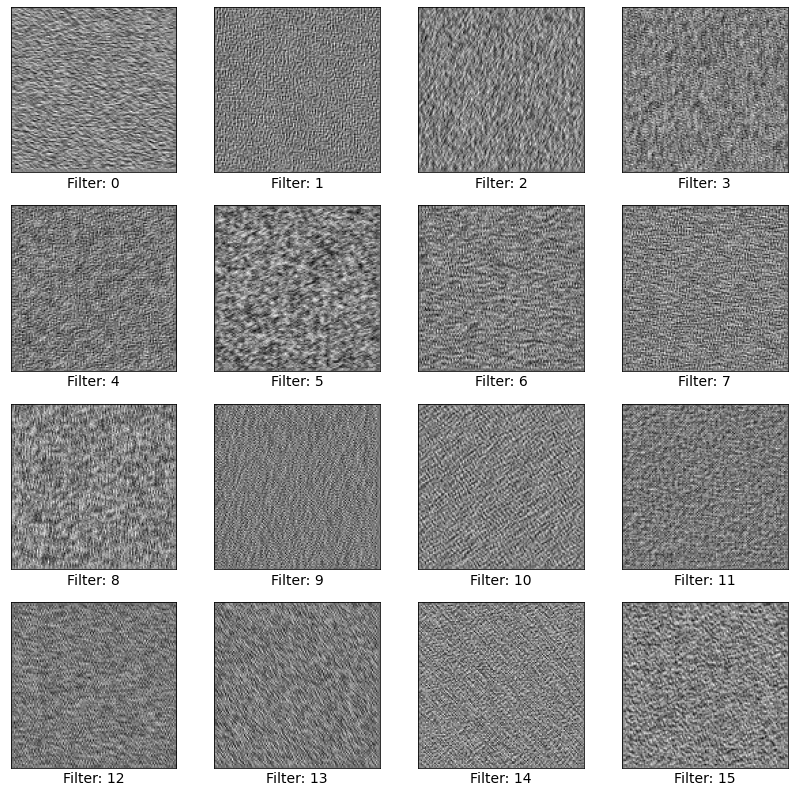

In [27]:
fig, axes = plt.subplots(4, 4, figsize=(14, 14))

for i, (ax, img) in enumerate(zip_longest(chain.from_iterable(axes), out_filters)):
    if ax is None:
        break
    
    if img is not None:
        _ = ax.imshow(img, cmap='gray')
    
    _ = ax.set_yticklabels([])
    _ = ax.set_xticklabels([])
    _ = ax.set_yticks([])
    _ = ax.set_xticks([])

    _ = ax.set_xlabel(f'Filter: {i}', fontsize=14)
    _ = ax.set(aspect='equal')

In [28]:
num_filters = 32
out_filters = []

for selected_filter in range(num_filters):
    visio = CNNLayerVisualization(
        model=net,
        selected_layer=list(net._conv.children())[5],
        selected_filter=selected_filter,
        # seed=1932,
    )

    res = visio.visualise(optimizer, opt_steps=32)
    res = res.cpu().detach().numpy()

    out_filters.append(res)

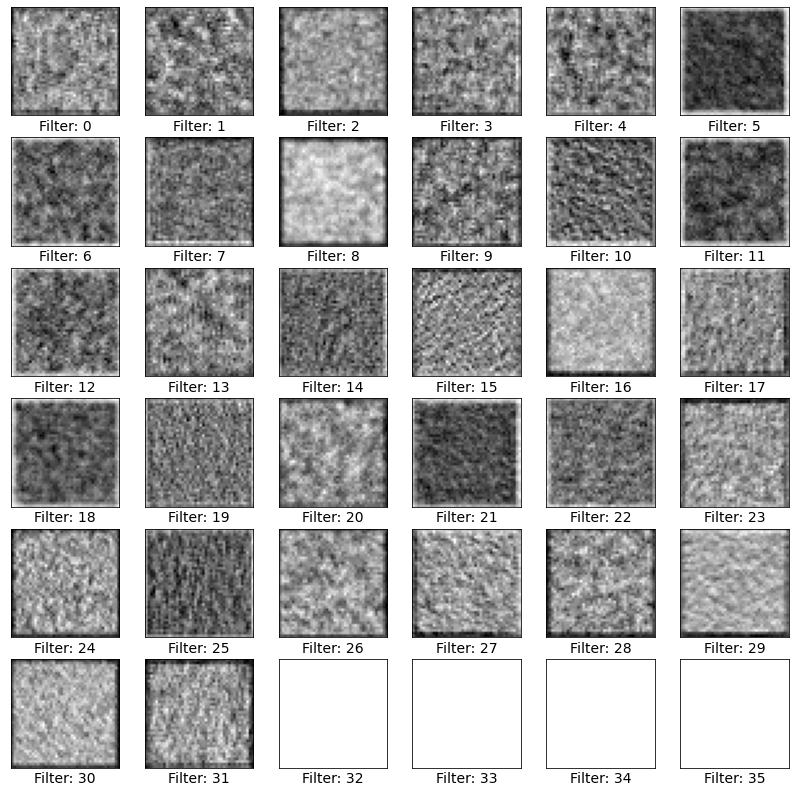

In [29]:
fig, axes = plt.subplots(6, 6, figsize=(14, 14))

for i, (ax, img) in enumerate(zip_longest(chain.from_iterable(axes), out_filters)):
    if ax is None:
        break
    
    if img is not None:
        _ = ax.imshow(img, cmap='gray')
    
    _ = ax.set_yticklabels([])
    _ = ax.set_xticklabels([])
    _ = ax.set_yticks([])
    _ = ax.set_xticks([])

    _ = ax.set_xlabel(f'Filter: {i}', fontsize=14)
    _ = ax.set(aspect='equal')

In [30]:
misclassified, errors = evaluate_func(net, valid, return_misclassified=True)
misclassified[:5], errors[:5]

batches: 100%|██████████| 49/49 [00:00<00:00, 90.99it/s]


(array(['-0.004240238573402166__CYGNO_60_40_ER_3_keV_930V_30cm_IDAO_iso_crop_hist_pic_run5_ev702;1.png',
        '-0.017457688227295876__CYGNO_60_40_ER_10_keV_930V_30cm_IDAO_iso_crop_hist_pic_run1_ev620;1.png',
        '-0.021928340196609497__CYGNO_60_40_ER_10_keV_930V_30cm_IDAO_iso_crop_hist_pic_run1_ev860;1.png',
        '-0.02293001301586628__CYGNO_60_40_ER_30_keV_930V_30cm_IDAO_iso_crop_hist_pic_run4_ev552;1.png',
        '-0.023109635338187218__CYGNO_60_40_ER_10_keV_930V_30cm_IDAO_iso_crop_hist_pic_run5_ev329;1.png'],
       dtype='<U103'), array([2, 2, 2, 2, 2]))

In [31]:
np.bincount(errors, minlength=4), errors.shape

(array([   0,  144, 4189,    8]), (4341,))

In [32]:
misclassified[errors == 3][:10]

array(['0.570262610912323__CYGNO_60_40_ER_3_keV_930V_30cm_IDAO_iso_crop_hist_pic_run1_ev803;1.png',
       '-0.8557000160217285__CYGNO_60_40_He_NR_6_keV_930V_30cm_SRIM_IDAO_iso_crop_hist_pic_run5_ev395;1.png',
       '2.9070000648498535__CYGNO_60_40_He_NR_20_keV_930V_30cm_SRIM_IDAO_iso_crop_hist_pic_run5_ev972;1.png',
       '80abcf3557352343616b309efd477d21f4f6fdc0.png',
       '2bb4781a5c907bc029a4337807505c4f22e74b7b.png',
       '8b49a27eba9c9d01184ae8ef02230964df814ae5.png',
       'aca45d09488253068ba48cb00352b0bea8169cb0.png',
       'af68ed45eb775715c7f128509b423cfa349ff476.png'], dtype='<U103')

In [33]:
import pandas as pd


def make_submission(model, iterator, verbose=True):
    model.eval()

    filenames_all = []
    labels_pred_all, values_pred_all = [], []

    if verbose:
        iterator_ = tqdm(iterator, position=0)
    else:
        iterator_ = iterator

    with torch.no_grad():
        for images, *_ in iterator_:
            images = images.to(device)
            labels_pred, values_pred = model(images)

            labels_pred = torch.sigmoid(labels_pred)
            labels_pred = labels_pred.cpu().detach().numpy().ravel()
            values_pred = values_pred.cpu().detach().numpy().argmax(axis=1).ravel()

            labels_pred_all.append(labels_pred)
            values_pred_all.append(values_pred)

    labels_pred = np.concatenate(labels_pred_all)
    values_pred = np.concatenate(values_pred_all)
    values_pred = MAPPING_VALUE_INV[values_pred]
    
    submission = pd.DataFrame()
    submission['id'] = iterator.filenames
    submission['classification_predictions'] = labels_pred
    submission['regression_predictions'] = values_pred

    submission['id'] = submission['id'].str.split('.').str[0]
    submission.set_index('id', inplace=True)

    return submission

In [34]:
%%time

dataset_public = IDAODataset.from_path(
    path='idao_dataset/public_test/',
    transform=dataset.transform,
    apply_transform_optional=False,
    has_target=False,
)

dataset_private = IDAODataset.from_path(
    path='idao_dataset/private_test_new/',
    transform=dataset.transform,
    apply_transform_optional=False,
    has_target=False,
)

100%|██████████| 15058/15058 [01:22<00:00, 182.80it/s]


CPU times: user 2.02 s, sys: 1.04 s, total: 3.06 s
Wall time: 1min 34s


In [35]:
submission_pull = []

for fold in range(1, len(dataset_folds) + 1):
    model_best = os.path.join(CHECKPOINTS, f'epoch_{epoch_best+1}', f'model_fold_{fold}.model')
    net.load_state_dict(torch.load(model_best))

    submission_pub = make_submission(net, dataset_public)
    submission_prv = make_submission(net, dataset_private)

    submission = pd.concat([submission_pub, submission_prv], axis=0)
    submission = submission.add_suffix(f'_{fold}')
    submission_pull.append(submission)

submission_pull = pd.concat(submission_pull, axis=1)

submission = pd.DataFrame(index=submission_pull.index)

mask = submission_pull.columns.str.startswith('classification_predictions_')
submission['classification_predictions'] = submission_pull.loc[:, mask].mean(axis=1).values

mask = submission_pull.columns.str.startswith('regression_predictions_')
submission['regression_predictions'] = submission_pull.loc[:, mask].mode(axis=1).mean(axis=1).values.astype(int)

submission.head()

100%|██████████| 118/118 [00:01<00:00, 88.04it/s]


,classification_predictions,regression_predictions
id,,
001ec8f4d2679f2899a63e4b2597c0a10bd9393f,0.000060,20
00327390bfd6101b87106e96e0efc1c938690e1f,0.000112,6
00573dde8addbac780cfa35a55a790fa1aa45178,0.000581,20
00cb5b91a4acdfaa2f55dc2266e598ff06f9209e,0.000222,6
00de1146bdcbfb02ed5f0e13fd6b9fe62157c0b2,0.000350,6


In [36]:
submission.shape

(16560, 2)

In [37]:
submission_name = os.path.join(WORK_DIR, 'submission_004-6-2.csv')
submission.to_csv(submission_name, index=True)

In [38]:
dataset_private = IDAODataset.from_path(
    path='idao_dataset/private_test/',
    transform=dataset.transform,
    apply_transform_optional=False,
    has_target=False,
)

100%|██████████| 15062/15062 [01:16<00:00, 196.45it/s]


In [39]:
submission_pull = []

for fold in range(1, len(dataset_folds) + 1):
    model_best = os.path.join(CHECKPOINTS, f'epoch_{epoch_best+1}', f'model_fold_{fold}.model')
    net.load_state_dict(torch.load(model_best))

    submission_pub = make_submission(net, dataset_public)
    submission_prv = make_submission(net, dataset_private)

    submission = pd.concat([submission_pub, submission_prv], axis=0)
    submission = submission.add_suffix(f'_{fold}')
    submission_pull.append(submission)

submission_pull = pd.concat(submission_pull, axis=1)

submission = pd.DataFrame(index=submission_pull.index)

mask = submission_pull.columns.str.startswith('classification_predictions_')
submission['classification_predictions'] = submission_pull.loc[:, mask].mean(axis=1).values

mask = submission_pull.columns.str.startswith('regression_predictions_')
submission['regression_predictions'] = submission_pull.loc[:, mask].mode(axis=1).mean(axis=1).values.astype(int)

submission.head()

100%|██████████| 118/118 [00:01<00:00, 90.49it/s]


,classification_predictions,regression_predictions
id,,
001ec8f4d2679f2899a63e4b2597c0a10bd9393f,0.000060,20
00327390bfd6101b87106e96e0efc1c938690e1f,0.000112,6
00573dde8addbac780cfa35a55a790fa1aa45178,0.000581,20
00cb5b91a4acdfaa2f55dc2266e598ff06f9209e,0.000222,6
00de1146bdcbfb02ed5f0e13fd6b9fe62157c0b2,0.000350,6


In [40]:
submission_name = os.path.join(WORK_DIR, 'submission_004-6-2_old.csv')
submission.to_csv(submission_name, index=True)